In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Standard plotly imports
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb


## Hyperopt modules
#from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import gc


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Import datasets**


* functions to assist with memory reduction [source of function](https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage) and dataset representation inspired by and outlier calculations

In [2]:
def resumetable(df,operator,threshold):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Missing Pct'] = (df.isnull().sum().values/len(df))*100
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)

    # Filter the summary dataframe based on the missing percentage threshold
    summary = summary[eval(f"summary['Missing Pct'] {operator} {threshold}")]

    # Sort the summary dataframe by 'Missing Pct' column in ascending order
    summary = summary.sort_values(by='Missing Pct')

    print(f"Dataset Shape: {summary.shape}")
    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df


def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_id = import_data('train_identity.csv')
df_tr = import_data('train_transaction.csv')

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)


Our Goals:
* To be able to predict which transactions are fraudulent 
* Understand the distribution of the data.(making sense of the data) 
* decide what to do with null values(mainly the features that have the nulls values)
* check the relationship of the null value columns with the target(isFraud) 

In getting to our goals there is a EDA which will be evolving as we try to improve our model performance.
therefore:
1. EDA
1. Pre-processing(since our data is Heavily imbalanced we must do something)
2. Split data into (Training/Test)(70/30) respectively
3.  

# make sense of the data

functions to assist with data visualisation

In [5]:

def hist_with_hue(df, col, hue):
    plt.figure(figsize=(13.5, 6))

    # Plotting the histogram with hue
    plt.subplot(1, 2, 1)
    sns.histplot(x=col, hue=hue, data=df, kde=True, palette='Set1')

    # Configure the x-axis
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.xticks(rotation=90, ha='center')

    plt.title(f"Distribution by {col}", fontweight="black", size=14, pad=10)

    # Plotting the boxplot with hue
    plt.subplot(1, 2, 2)
    sns.boxplot(x=hue, y=col, data=df, palette='Set2')

    plt.title(f"Distribution by {col} & {hue}", fontweight="black", size=14, pad=10)

    plt.tight_layout()
    plt.show()
    
    
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow, hue):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]  # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = round((nCol + nGraphPerRow) / nGraphPerRow)
    plt.figure(figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        
        if not np.issubdtype(columnDf.dtype, np.number):
            sns.countplot(data=df, x=columnDf, hue=hue)
        else:
            sns.histplot(data=df, x=columnDf, hue=hue, kde=False, bins=30)
        
        plt.ylabel('Counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

In [6]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df_tr['isFraud'].value_counts()[0]/len(df_tr) * 100,2), '% of the dataset')
print('Frauds', round(df_tr['isFraud'].value_counts()[1]/len(df_tr) * 100,2), '% of the dataset')

No Frauds 96.5 % of the dataset
Frauds 3.5 % of the dataset


**Merge Identity and transaction dataset**

In [7]:
train_df = df_tr.merge(df_id,how='left',left_index=True,right_index=True)

In [8]:
train_df.shape

(590540, 435)

In [9]:
resumetable(train_df,">=",70) 

Dataset Shape: (590540, 435)
Dataset Shape: (209, 9)


,Name,dtypes,Missing,Missing Pct,Uniques,First Value,Second Value,Third Value,Entropy
394,TransactionID_y,float64,446307,75.576083,144233,2987004.0,2987008.0,2987010.0,17.14
395,id_01,float16,446307,75.576083,77,0.0,-5.0,-5.0,2.27
406,id_12,object,446307,75.576083,2,NotFound,NotFound,NotFound,0.60
309,V255,float16,449124,76.053104,46,NaN,NaN,NaN,0.90
310,V256,float16,449124,76.053104,48,NaN,NaN,NaN,0.93
...,...,...,...,...,...,...,...,...,...
415,id_21,float16,585381,99.126393,490,NaN,NaN,NaN,4.63
402,id_08,float16,585385,99.127070,94,NaN,NaN,NaN,5.72
401,id_07,float16,585385,99.127070,84,NaN,NaN,NaN,5.39
419,id_25,float16,585408,99.130965,341,NaN,NaN,NaN,4.46


In [10]:
train_df.shape

(590540, 435)

***error*** bar(train_df,"isFraud","TransactionAmt","Transactions Distribution","Total Amount in Transaction Amt")

we have alot of dimensions, reducing these should take priority however preservation of information is to be considered
* feature selection/importance

Categorical Features - Transaction

ProductCD
card1 - card6
addr1, addr2
P_emaildomain
R_emaildomain
M1 - M9
Categorical Features - Identity

DeviceType
DeviceInfo
id_12 - id_38


# Univariate Analysis

In [11]:
round((235 + 5-1) / 5)

48

plotPerColumnDistribution(train_df, 20, 5,'isFraud')

remove TransactionID_x, TransactionID_y, and TransactionDT

In [12]:
train_df.drop(columns=['TransactionID_x', 'TransactionDT'], inplace=True)

In [13]:
# Categoric Columns are taken from Data tab of competition 
categoric_columns = ['ProductCD',
                     'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                     'addr1', 'addr2',
                     'P_emaildomain', 'R_emaildomain',
                     'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                     'DeviceType', 'DeviceInfo',
                     'id_12', 'id_13', 'id_14', 'id_15', 'id_16','id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
                     'id_25', 'id_26','id_27','id_28','id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34','id_35', 'id_36', 'id_37', 'id_38']
numeric_columns = []

for i in train_df.columns:
    if i not in categoric_columns:
        numeric_columns.append(i)

print('Numerical columns: ', numeric_columns)
print('Categoric columns: ', categoric_columns)

Numerical columns:  ['isFraud', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107',

In [14]:
numeric_columns.remove('isFraud')

In [15]:
train_df[numeric_columns] = train_df[numeric_columns].astype('float64')

# Normalization and Encoding

In [16]:
# Initialize the scaler and encoder
scaler = StandardScaler()
encoder = LabelEncoder()
    
# Normalize numerical columns
train_df[numeric_columns] = scaler.fit_transform(train_df[numeric_columns])
    
# Encode categorical columns
for column in categoric_columns:
    train_df[column] = encoder.fit_transform(train_df[column])

In [17]:
train_df.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,-0.278174,4,10095,500,42,1,38,1,166,...,123,3,164,3,1,0,1,1,1,954
1,0,-0.443337,4,1372,303,42,2,2,1,173,...,98,3,48,2,1,0,0,1,1,1727
2,0,-0.317897,4,2833,389,42,3,58,2,178,...,44,4,260,4,0,0,1,1,0,1598
3,0,-0.355529,4,13341,466,42,2,14,2,282,...,44,4,260,4,0,0,1,1,0,1786
4,0,-0.355529,1,2712,413,42,2,2,1,241,...,44,2,40,3,1,0,1,1,0,723


# Handle Class Imbalance (isFraud)

In [18]:
(train_df['isFraud'] == 0).sum(), (train_df['isFraud'] == 1).sum()

(569877, 20663)

In [19]:
from sklearn.utils import resample

# Separate the majority and minority classes
minority_class = train_df[train_df['isFraud'] == 1]
majority_class = train_df[train_df['isFraud'] == 0]

# Upsample the minority class
minority_upsampled = resample(minority_class, 
                              replace=True,     # sample with replacement
                              n_samples=len(majority_class),  # match number in majority class
                              random_state=42)  # reproducible results

# Combine the upsampled minority class with the majority class
train_df_balanced = pd.concat([minority_upsampled, majority_class])

# Shuffle the resulting dataframe to mix the classes
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the distribution of the classes
print(train_df_balanced['isFraud'].value_counts())

isFraud
1    569877
0    569877
Name: count, dtype: int64


In [20]:
train_df = train_df_balanced

In [21]:
print(train_df['isFraud'].value_counts())

isFraud
1    569877
0    569877
Name: count, dtype: int64


before we visualise the numerical columns

In [22]:
# Calculate the percentage of null values in each column
null_percentage = train_df.isnull().mean() * 100

In [23]:
# Set a threshold for the null percentage
threshold = 60  # For example, consider columns with more than 60% null values
# Filter the columns based on the null percentage threshold
filtered_columns = null_percentage[null_percentage > threshold].index
print(filtered_columns)

Index(['dist1', 'dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138',
       ...
       'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09',
       'id_10', 'id_11'],
      dtype='object', length=180)


In [24]:
# Create a new DataFrame with the filtered columns
train_df_filtered = train_df[filtered_columns]

In [25]:
for i in filtered_columns:
    if i in categoric_columns:
        categoric_columns.remove(i)
    else:
        if i in numeric_columns:
            numeric_columns.remove(i)
            
print('Numerical columns: ', numeric_columns)
print('Categoric columns: ', categoric_columns)

Numerical columns:  ['TransactionAmt', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', '

Distribution of all numeric colums

**Statistical Analysis - Feature Importance**

1. Performing ANOVA Test to Analyze the Numerical Features Importance in Fraud detection.

In [26]:
f_scores = {}
p_values = {}

for column in numeric_columns[:20]:
    f_score, p_value = stats.f_oneway(train_df[column], train_df["isFraud"])
    
    f_scores[column] = f_score
    p_values[column] = p_value

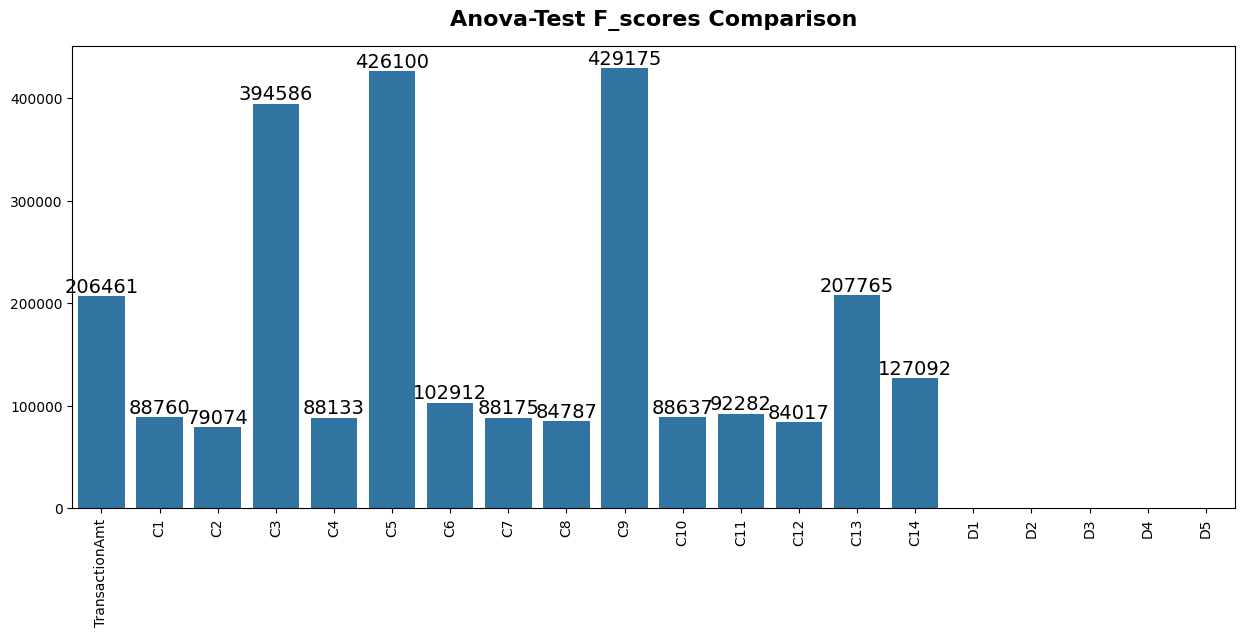

In [27]:
# Assuming f_scores is a dictionary with keys and values
keys = list(f_scores.keys())
values = list(f_scores.values())

plt.figure(figsize=(15, 6))
sns.barplot(x=keys, y=values)
plt.title("Anova-Test F_scores Comparison", fontweight="black", size=16, pad=15)
plt.xticks(rotation=90)

# Adding annotations
for index, value in enumerate(values):
    if not np.isnan(value):  # Check if the value is not NaN
        plt.text(index, value, f'{int(value)}', ha='center', va='bottom', size=14)

plt.show()

# Train Test Split

In [28]:
X = train_df.drop(columns='isFraud')
y = train_df['isFraud']

In [29]:
X.shape

(1139754, 432)

In [30]:
y.shape

(1139754,)

In [31]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=42)

# Model Test

In [32]:
from xgboost import XGBClassifier

# Instantiate XGBoost classifier
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [33]:
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.88      0.92      0.90    113773
           1       0.92      0.88      0.90    114178

    accuracy                           0.90    227951
   macro avg       0.90      0.90      0.90    227951
weighted avg       0.90      0.90      0.90    227951



In [34]:
# Predict probabilities for the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (positive class)

In [35]:
from sklearn.metrics import roc_auc_score

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc_roc:.2f}")

AUC-ROC Score: 0.97


# **Lets test with our test dataset**

In [36]:
df_test_id = import_data('test_identity.csv')
df_test_tr = import_data('test_transaction.csv')

Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)


In [37]:
df_test_tr.shape

(506691, 393)

Our training dataset has more records than our testing dataset

In [38]:
tr_rows,tr_columns = train_df.shape
te_rows,te_columns = df_test_tr.shape

print(f'The difference in rows is training rows {tr_rows} minus testing rows {te_rows} = {tr_rows - te_rows}')

The difference in rows is training rows 1139754 minus testing rows 506691 = 633063
